# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [142]:
# Import your libraries:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd
import seaborn as sns

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [143]:
websites = pd.read_csv('../website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [144]:
# Your code here
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [145]:
websites['Type'].value_counts()

0    1565
1     216
Name: Type, dtype: int64

In [146]:
websites.info() 
# 1781 filas y 21 columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
URL                          1781 non-null object
URL_LENGTH                   1781 non-null int64
NUMBER_SPECIAL_CHARACTERS    1781 non-null int64
CHARSET                      1781 non-null object
SERVER                       1780 non-null object
CONTENT_LENGTH               969 non-null float64
WHOIS_COUNTRY                1781 non-null object
WHOIS_STATEPRO               1781 non-null object
WHOIS_REGDATE                1781 non-null object
WHOIS_UPDATED_DATE           1781 non-null object
TCP_CONVERSATION_EXCHANGE    1781 non-null int64
DIST_REMOTE_TCP_PORT         1781 non-null int64
REMOTE_IPS                   1781 non-null int64
APP_BYTES                    1781 non-null int64
SOURCE_APP_PACKETS           1781 non-null int64
REMOTE_APP_PACKETS           1781 non-null int64
SOURCE_APP_BYTES             1781 non-null int64
REMOTE_APP_BYTES             1781 non-null int64
APP

In [147]:
null_cols = websites.isnull().sum()
null_cols[null_cols > 0]
# 'CONTENT_LENGTH' tiene casi la mitad de datos nulos y en 'DNS_QUERY_TIMES' y 'SERVER' aparece un dato nulo
# Por lo tanto 'CONTENT_LENGTH' podría ser eliminada

SERVER               1
CONTENT_LENGTH     812
DNS_QUERY_TIMES      1
dtype: int64

In [148]:
#websites['SERVER'].unique()

In [149]:
websites['WHOIS_COUNTRY'].unique()
#websites['WHOIS_COUNTRY'].value_counts()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [150]:
websites['CHARSET'].unique()
websites['CHARSET'].value_counts()

UTF-8           676
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
windows-1252      1
windows-1251      1
ISO-8859          1
Name: CHARSET, dtype: int64

In [151]:
# Your comment here
# Vamos a predecir el valor de la columna Type

# Como ya se ha escogido la columna Type para predecirla, el resto se analizará para utilizarlas como features

# En la url se especifica los site malos con una M al inicio y los buenos con una B, así mismo en la
# columna Type los malos están marcados con un 1 y los buenos con un cero

# En cuanto a las columnas que tienen categorías que queremos convertir. 
# Candidatas pueden ser WHOIS_COUNTRY y CHARSET, aunque tienen datos que habría que arreglar
# y hay demasiados valores desconocidos, sobre todo en WHOIS_COUNTRY

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [152]:
# Your code here
websites_corr = websites.corr() # corr() solo realiza la correlación de las columnas con valores numéricos
websites_corr.head(websites_corr.shape[0])

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048,0.280897
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852


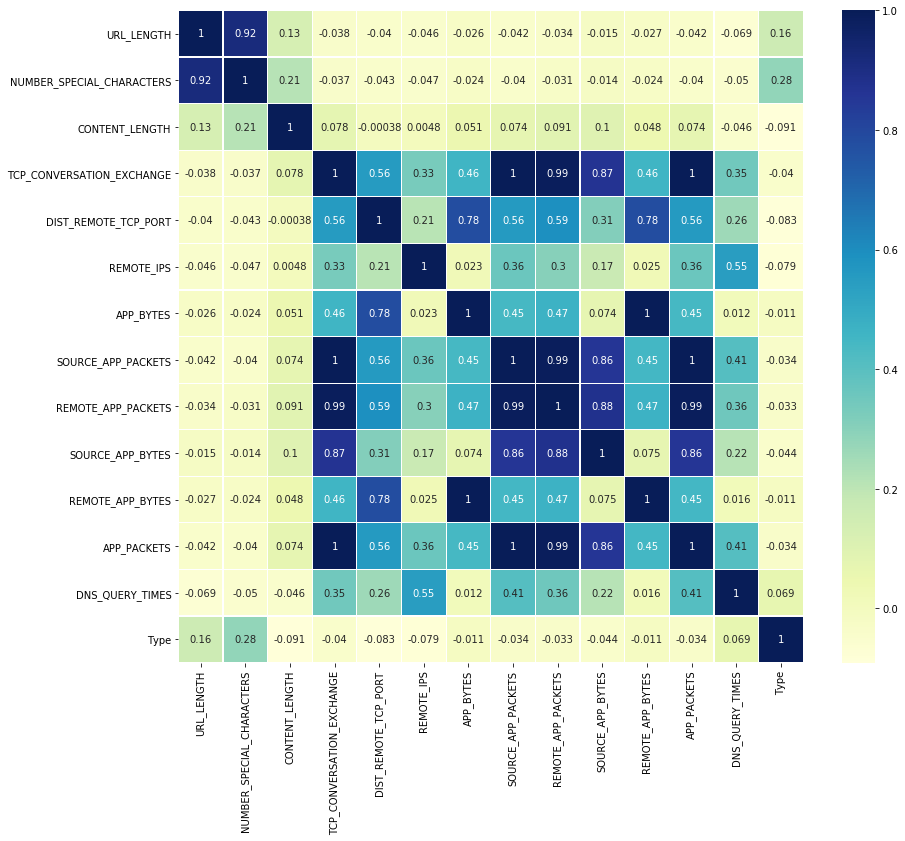

In [153]:
plt.figure(figsize = (14,12))
sns.heatmap(websites_corr, linewidths =.2 ,cmap = 'YlGnBu', annot = True)
plt.yticks(rotation = 0);

In [154]:
# Your comment here
# URL_LENGTH tiene alta correlación con TYPE
# NUMBER_SPECIAL_CHARACTERS tiene alta correlación con TYPE
#
# TCP_CONVERSATION_EXCHANGE con APP_PACKETS y así bastantes más, 
# a priori veo complejo decidir por unas en concreto

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [155]:
# Your code here

def mas_repetidos(lista, num):
    '''
    Los elementos que se repiten más de un 
    número de veces
    '''
    repetidos = []
    for i in lista:
        if lista.count(i) >= num and i not in repetidos:
            repetidos.append(i)

    return repetidos  

In [156]:
def mayor_correlacion(matrix, correlacion):
    '''
    Devuelve una lista con las columnas que tienen
    una correlación mayor o igual a la dada
    '''
    lista_mayor = []
    columnas = matrix.columns
    
    for col, fila in (matrix.abs() > correlacion).iteritems():
        for e in columnas[fila.values]:
            lista_mayor.append(e)
            
    #Devuelvo las columnas que se repiten al menos dos veces   
    
    return mas_repetidos(lista_mayor, 2)

In [157]:
columnas = mayor_correlacion(websites_corr, 0.9)
columnas

['URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'TCP_CONVERSATION_EXCHANGE',
 'SOURCE_APP_PACKETS',
 'REMOTE_APP_PACKETS',
 'APP_PACKETS',
 'APP_BYTES',
 'REMOTE_APP_BYTES']

In [158]:
# Your comment here
# Quedan pocas columnas númericas, aunque en el dataframe hay varias categóricas  
# de las cuales algunas se pasarán a numéricas

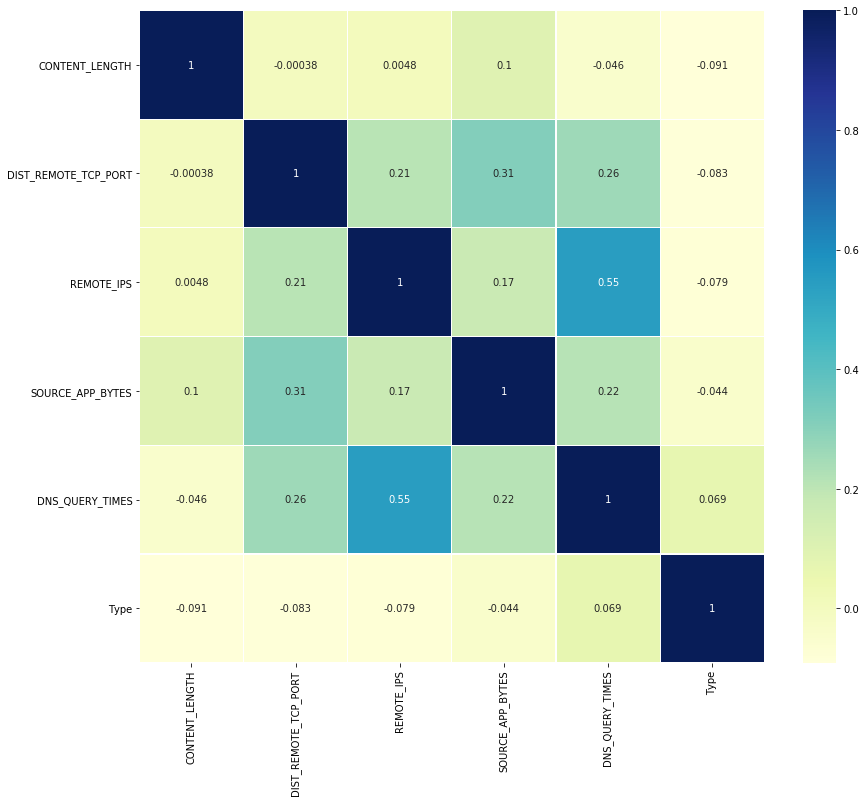

In [159]:
# Print heatmap again
websites_temp = websites.drop(columns = columnas).copy()
websites_temp.head()

plt.figure(figsize = (14,12))
sns.heatmap(websites_temp.corr(),linewidths=.1 ,cmap="YlGnBu", annot = True)
plt.yticks(rotation = 0);

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [160]:
# Your code here
websites = websites.drop(columns = columnas)
null_cols = websites.isnull().sum()
null_cols[null_cols > 0]

SERVER               1
CONTENT_LENGTH     812
DNS_QUERY_TIMES      1
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [161]:
# Your code here
websites.drop(['CONTENT_LENGTH'], axis = 1, inplace = True)
websites = websites.dropna()

In [162]:
# Your comment here
# 'CONTENT_LENGTH' casi la mitad de los registros nulos
# También se eliminan los registros con nulos, en este caso 2

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [163]:
# Examine missing values in each column
null_cols = websites.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

In [164]:
websites.head()

,URL,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,iso-8859-1,nginx,None,None,10/10/2015 18:21,None,0,2,1153,2.0,1
1,B0_2314,UTF-8,Apache/2.4.10,None,None,None,None,7,4,1265,0.0,0
2,B0_911,us-ascii,Microsoft-HTTPAPI/2.0,None,None,None,None,0,0,0,0.0,0
3,B0_113,ISO-8859-1,nginx,US,AK,7/10/1997 4:00,12/09/2013 0:45,22,3,18784,8.0,0
4,B0_403,UTF-8,None,US,TX,12/05/1996 0:00,11/04/2017 0:00,2,5,129889,4.0,0


# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [165]:
# Your code here
websites['WHOIS_COUNTRY'].unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [166]:
cambiar = {"United Kingdom" : "GB", 
            "[u'GB'; u'UK']" : "GB",
            "Cyprus" : "CY"}

websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace(to_replace = cambiar).apply(lambda x : x.upper())

In [167]:
websites['WHOIS_COUNTRY'].unique()

array(['NONE', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN',
       'LU', 'TH', 'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT',
       'CZ', 'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'BR', 'KR', 'HK',
       'UA', 'CH', 'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

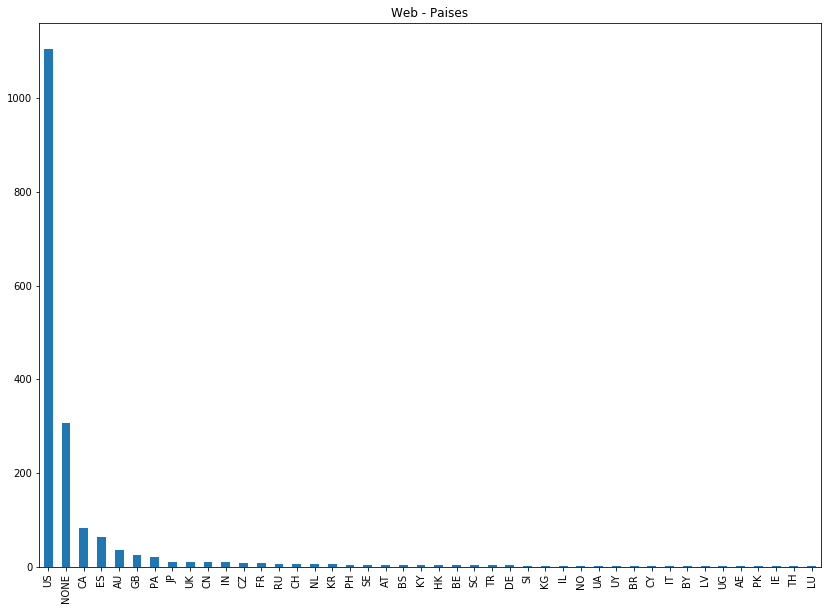

In [168]:
# Your code here
web_paises = websites['WHOIS_COUNTRY'].value_counts()
web_paises.plot(kind = 'bar', title = 'Web - Paises', figsize = (14, 10))

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [169]:
# Your code here
pais_10 = websites['WHOIS_COUNTRY'].value_counts()[:10]

In [170]:
def rename_other(pais, lista = pais_10):
    '''
    Renombra como OTHER los paises
    que no están en la lista
    '''
    if pais not in lista:
        pais = 'OTHER'
    return pais

websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(rename_other)
websites['WHOIS_COUNTRY'].value_counts()

US       1105
NONE      306
OTHER     110
CA         83
ES         63
AU         35
GB         25
PA         21
JP         11
CN         10
UK         10
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [171]:
# Your code here
websites.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis = 1, inplace = True)
websites.head()

,URL,CHARSET,SERVER,WHOIS_COUNTRY,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,iso-8859-1,nginx,NONE,0,2,1153,2.0,1
1,B0_2314,UTF-8,Apache/2.4.10,NONE,7,4,1265,0.0,0
2,B0_911,us-ascii,Microsoft-HTTPAPI/2.0,NONE,0,0,0,0.0,0
3,B0_113,ISO-8859-1,nginx,US,22,3,18784,8.0,0
4,B0_403,UTF-8,None,US,2,5,129889,4.0,0


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [172]:
# Your code here
websites.dtypes

URL                      object
CHARSET                  object
SERVER                   object
WHOIS_COUNTRY            object
DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
SOURCE_APP_BYTES          int64
DNS_QUERY_TIMES         float64
Type                      int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [173]:
# Your code here
websites.drop(['URL'], axis = 1, inplace = True)
websites.head()

,CHARSET,SERVER,WHOIS_COUNTRY,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
0,iso-8859-1,nginx,NONE,0,2,1153,2.0,1
1,UTF-8,Apache/2.4.10,NONE,7,4,1265,0.0,0
2,us-ascii,Microsoft-HTTPAPI/2.0,NONE,0,0,0,0.0,0
3,ISO-8859-1,nginx,US,22,3,18784,8.0,0
4,UTF-8,None,US,2,5,129889,4.0,0


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [174]:
# Your code here
websites['CHARSET'].value_counts()

UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
windows-1252      1
windows-1251      1
ISO-8859          1
Name: CHARSET, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [175]:
# Your code here
#websites['SERVER'].value_counts()
websites['SERVER'].value_counts()[:10] #Lo he acotado a unos pocos para que no quede tan largo

Apache                   385
nginx                    211
None                     175
Microsoft-HTTPAPI/2.0    113
cloudflare-nginx          94
Microsoft-IIS/7.5         51
GSE                       49
Server                    49
YouTubeFrontEnd           42
nginx/1.12.0              36
Name: SERVER, dtype: int64

![Think Hard](../think-hard.jpg)

In [176]:
# Your comment here
# Habría que utlizar los que más se repitan, renombrarlos y al resto agruparlos con un valor 

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [177]:
# Your code here
buscar = ['Microsoft', 'Apache', 'nginx']
def renombra_server(servidor, lista = buscar):
    '''
    Busca un servidor de la lista en
    la variable pasada
    '''
    for e in lista:
        if e in servidor:
            return e
    return 'Other'
        

In [178]:
websites['SERVER'] = websites['SERVER'].apply(renombra_server)

In [179]:
# Count `SERVER` value counts here
websites['SERVER'].value_counts()

Apache       642
Other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [180]:
# Your code here
website_dummy = pd.get_dummies(websites, drop_first = True)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [181]:
# Your code here
website_dummy.dtypes

DIST_REMOTE_TCP_PORT      int64
REMOTE_IPS                int64
SOURCE_APP_BYTES          int64
DNS_QUERY_TIMES         float64
Type                      int64
CHARSET_ISO-8859-1        uint8
CHARSET_None              uint8
CHARSET_UTF-8             uint8
CHARSET_iso-8859-1        uint8
CHARSET_us-ascii          uint8
CHARSET_utf-8             uint8
CHARSET_windows-1251      uint8
CHARSET_windows-1252      uint8
SERVER_Microsoft          uint8
SERVER_Other              uint8
SERVER_nginx              uint8
WHOIS_COUNTRY_CA          uint8
WHOIS_COUNTRY_CN          uint8
WHOIS_COUNTRY_ES          uint8
WHOIS_COUNTRY_GB          uint8
WHOIS_COUNTRY_JP          uint8
WHOIS_COUNTRY_NONE        uint8
WHOIS_COUNTRY_OTHER       uint8
WHOIS_COUNTRY_PA          uint8
WHOIS_COUNTRY_UK          uint8
WHOIS_COUNTRY_US          uint8
dtype: object

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

# Your code here:
X = website_dummy.drop(axis=1, labels=["Type"])
y = website_dummy['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [187]:
# Your code here:
model_log = LogisticRegression(penalty = 'l2', 
                                solver = 'liblinear', 
                                C = 5.0 )

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [188]:
# Your code here:
model_log.fit(X_train, y_train)


LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [189]:
# Your code here:
#y_pred = model_log.predict(X_test)
y_pred = cross_val_predict(model_log, X_test, y_test, cv = 3)
confusion_log = confusion_matrix(y_test, y_pred)
accuaracy_log = accuracy_score(y_test, y_pred)

print('Matriz Confusión\n {} \n\n Accuaracy: {}'.format(confusion_log, accuaracy_log))


Matriz Confusión
 [[304   8]
 [ 43   1]] 

 Accuaracy: 0.8567415730337079


In [190]:
columnas_filas = ['Bueno', 'Malo']
def dibuja_matriz(matrix, title, columnas):
    '''
    Para dibujar la matriz de confusión
    
    '''
    df = pd.DataFrame(matrix, 
                         index = [i for i in columnas],
                         columns = [i for i in columnas])

    plt.figure(figsize = (10,8))
    sns.heatmap(df ,linewidths = .1, cmap = 'YlGnBu', fmt = '.1f', annot = True)
    plt.title(title)
    plt.yticks(rotation = 0);


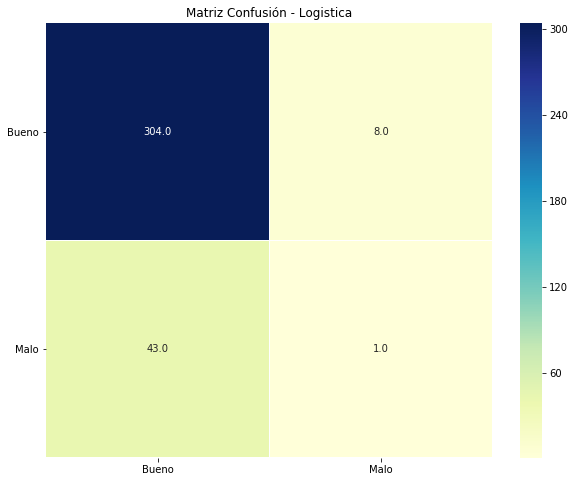

In [192]:
dibuja_matriz(confusion_log, 'Matriz Confusión - Logistica', columnas_filas)

What are your thoughts on the performance of the model? Write your conclusions below.

In [193]:
# Your conclusions here:

# Está cerca del 85% de Accuaracy , Identifica mejor los buenos que los malos
# Esto puede ser debido a que en el data hay más registros buenos que malos

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [199]:
# Your code here:
from sklearn.neighbors import KNeighborsClassifier 

model_kn = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)


To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [207]:
# Your code here:
y_pred_kn = model_kn.predict(X_test)
#y_pred_kn = cross_val_predict(model_kn, X_test, y_test, cv = 3)
confusion_kn = confusion_matrix(y_test, y_pred_kn)
accuaracy_kn = accuracy_score(y_test, y_pred_kn)

print('Matriz Confusión\n {} \n\n Accuaracy: {}'.format(confusion_kn, accuaracy_kn))


Matriz Confusión
 [[300  12]
 [ 15  29]] 

 Accuaracy: 0.9241573033707865


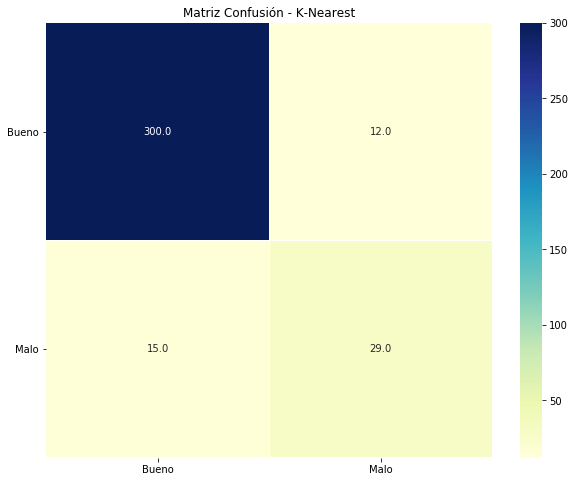

In [208]:
dibuja_matriz(confusion_kn, 'Matriz Confusión - K-Nearest', columnas_filas)

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [209]:
# Your code here:
model_kn2 = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

In [210]:
y_pred_kn2 = model_kn2.predict(X_test)
#y_pred_kn2 = cross_val_predict(model_kn2, X_test, y_test, cv = 3)
confusion_kn2 = confusion_matrix(y_test, y_pred_kn2)
accuaracy_kn2 = accuracy_score(y_test, y_pred_kn2)

print('Matriz Confusión\n {} \n\n Accuaracy: {}'.format(confusion_kn2, accuaracy_kn2))

Matriz Confusión
 [[296  16]
 [ 24  20]] 

 Accuaracy: 0.8876404494382022


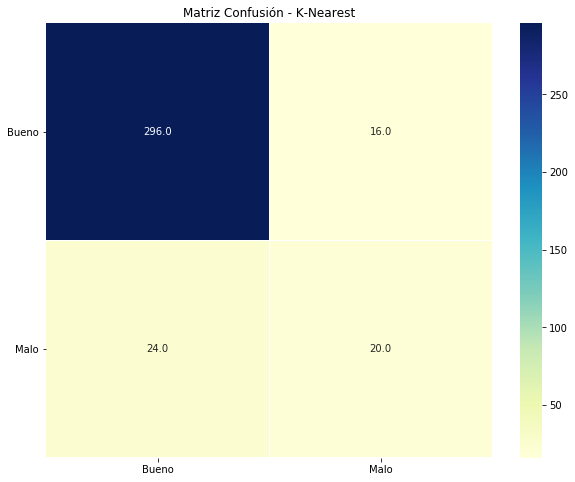

In [211]:
dibuja_matriz(confusion_kn2, 'Matriz Confusión - K-Nearest', columnas_filas)

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [212]:
# Your conclusions here:

# Ha empeorado un poco, habría que jugar un poco con los metaparámetros y realizar más pruebas
# Si continua así se podría cambiar de método para ver si el resultado mejora

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [222]:
# Your code here
from sklearn.preprocessing import RobustScaler

In [223]:
X_scale_train = RobustScaler().fit_transform(X_train)
X_scale_test = RobustScaler().fit_transform(X_test)

In [224]:
model_scale_log = LogisticRegression(penalty = 'l2', 
                                    solver = 'liblinear', 
                                    C = 5.0 )

In [225]:
model_scale_log.fit(X_scale_train, y_train)

LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [226]:
y_scale_pred = model_scale_log.predict(X_scale_test)
#y_scale_pred = cross_val_predict(model_scale_log, X_test, y_test, cv = 3) #probando con cross_val_predict
confusion_scale_log = confusion_matrix(y_test, y_scale_pred)
accuaracy__scale_log = accuracy_score(y_test, y_scale_pred)

print('Matriz Confusión\n {} \n\n Accuaracy: {}'.format(confusion_scale_log, 
                                                        accuaracy__scale_log))

Matriz Confusión
 [[307   5]
 [ 28  16]] 

 Accuaracy: 0.9073033707865169


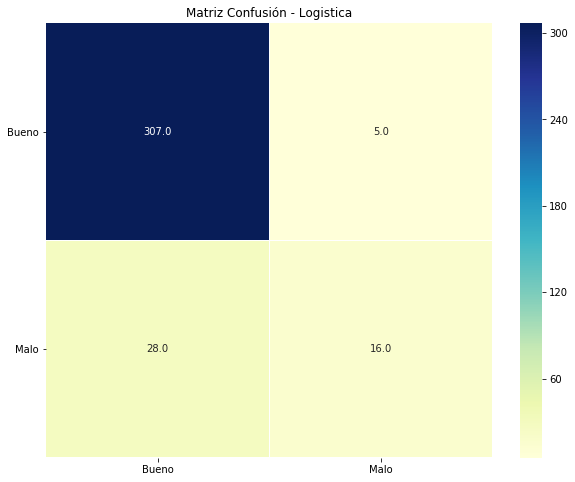

In [227]:
dibuja_matriz(confusion_scale_log, 'Matriz Confusión - Logistica', columnas_filas)

In [221]:
# Ha mejorado algo con respecto a las demás